In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.makedirs('data', exist_ok=True)

!cp /content/drive/MyDrive/FER2013_data/*.joblib data/

print("Files are copied from Drive")
!ls data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files are copied from Drive
label_encoder.joblib  X_train_p.joblib	y_test.joblib	y_val.joblib
X_test_p.joblib       X_val_p.joblib	y_train.joblib


In [2]:
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# GPU
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Download from folder data/
label_encoder = joblib.load("data/label_encoder.joblib")
num_classes = len(label_encoder.classes_)

X_train = joblib.load("data/X_train_p.joblib")
X_val = joblib.load("data/X_val_p.joblib")
X_test = joblib.load("data/X_test_p.joblib")
y_train = joblib.load("data/y_train.joblib")
y_val = joblib.load("data/y_val.joblib")
y_test = joblib.load("data/y_test.joblib")

# Encode labels
y_train_int = label_encoder.transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

# One-hot encode
y_train_cat = to_categorical(y_train_int, num_classes)
y_val_cat = to_categorical(y_val_int, num_classes)
y_test_cat = to_categorical(y_test_int, num_classes)

# Add channel dimension
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

print("Label classes:", label_encoder.classes_)
print("Train shape:", X_train_cnn.shape, y_train_cat.shape)
print("Data loaded successfully!")

Label classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Train shape: (25120, 48, 48, 1) (25120, 7)
Data loaded successfully!


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# class weights
classes = np.arange(num_classes)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_int)
cwdict = {i: float(w) for i, w in enumerate(class_weights)}

print("Class weights:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls}: {cwdict[i]:.4f}")

Class weights:
  angry: 1.0265
  disgust: 9.4188
  fear: 1.0010
  happy: 0.5684
  neutral: 0.8261
  sad: 0.8492
  surprise: 1.2932


In [5]:
# IMPROVED CNN
improved_cnn = models.Sequential([
    layers.Input(shape=(48, 48, 1)),

    # Layer 1
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Layer 2
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Layer 3
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Layer 4
    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    # Dense
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

improved_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,826,055 (18.41 MB)

 Trainable params: 4,821,703 (18.39 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [6]:
improved_cnn.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'improved_cnn_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("Model compiled!")

Model compiled!


In [7]:
# TRAINING: IMPROVED CNN
history = improved_cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=80,
    batch_size=64,
    class_weight=cwdict,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=2
)

improved_cnn.save('improved_cnn_final.keras')
print("\nModel saved!")

Epoch 1/80

Epoch 1: val_accuracy improved from -inf to 0.16328, saving model to improved_cnn_best.keras
393/393 - 47s - 121ms/step - accuracy: 0.1664 - loss: 2.4119 - val_accuracy: 0.1633 - val_loss: 2.5135 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_accuracy improved from 0.16328 to 0.25913, saving model to improved_cnn_best.keras
393/393 - 16s - 40ms/step - accuracy: 0.2127 - loss: 1.9617 - val_accuracy: 0.2591 - val_loss: 1.7659 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_accuracy improved from 0.25913 to 0.36361, saving model to improved_cnn_best.keras
393/393 - 16s - 41ms/step - accuracy: 0.2793 - loss: 1.7652 - val_accuracy: 0.3636 - val_loss: 1.6283 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_accuracy improved from 0.36361 to 0.40708, saving model to improved_cnn_best.keras
393/393 - 20s - 52ms/step - accuracy: 0.3592 - loss: 1.6168 - val_accuracy: 0.4071 - val_loss: 1.5304 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_accuracy improved from 0.

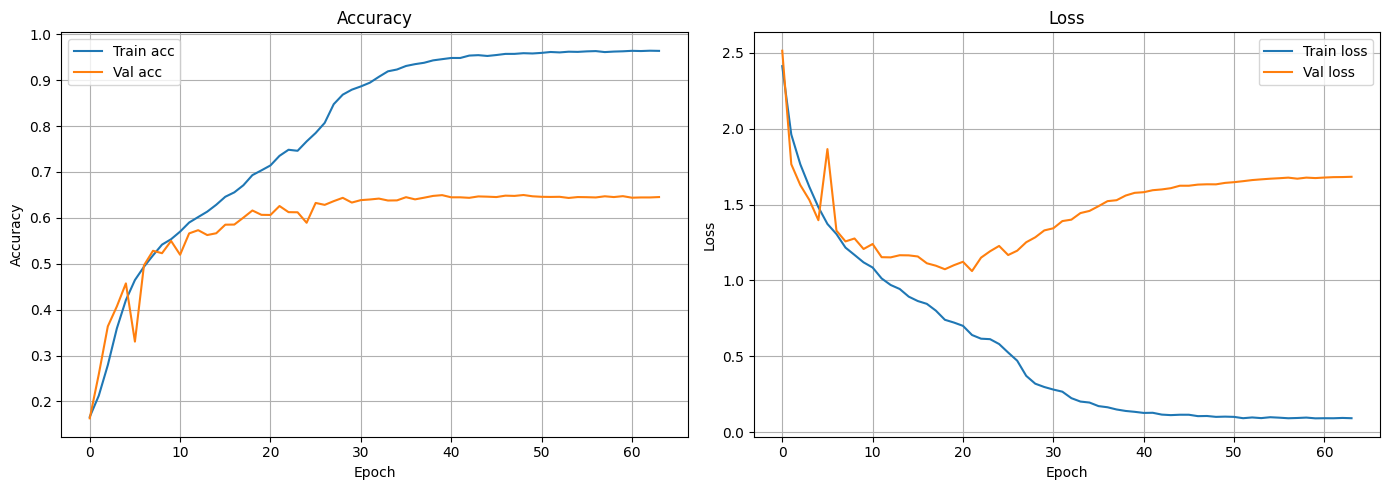

In [8]:
# Accuracy & Loss plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train acc')
axes[0].plot(history.history['val_accuracy'], label='Val acc')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Train loss')
axes[1].plot(history.history['val_loss'], label='Val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Save into Drive
!cp improved_cnn_best.keras /content/drive/MyDrive/FER2013_data/
!cp improved_cnn_final.keras /content/drive/MyDrive/FER2013_data/

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
VALIDATION RESULTS
              precision    recall  f1-score   support

       angry     0.6375    0.5110    0.5673       499
     disgust     0.5185    0.5091    0.5138        55
        fear     0.5148    0.5449    0.5294       512
       happy     0.8295    0.8415    0.8354       902
     neutral     0.5723    0.6248    0.5974       621
         sad     0.5073    0.5199    0.5135       604
    surprise     0.8110    0.7803    0.7954       396

    accuracy                         0.6498      3589
   macro avg     0.6273    0.6188    0.6217      3589
weighted avg     0.6524    0.6498    0.6498      3589

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

TEST RESULTS
              precision    recall  f1-score   support

       angry     0.6276    0.5136    0.5649       958
     disgust     0.6348    0.6577    0.6460       111
        fear     0.4936    0.4883    0.4909      1024
       happy     0.8278    0.8455    0.8366      1774
     neutral   

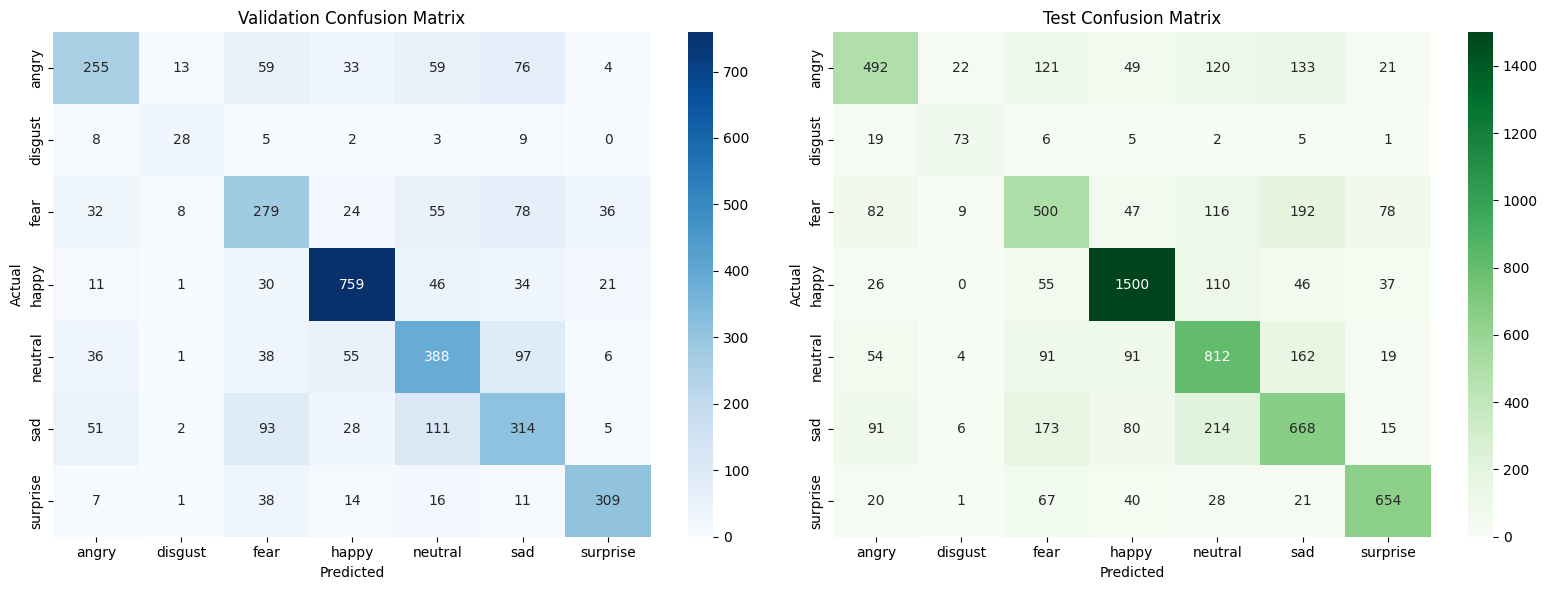


Validation Accuracy: 0.6498 (64.98%)
Test Accuracy:       0.6546 (65.46%)


In [9]:
# VALIDATION
y_val_pred = improved_cnn.predict(X_val_cnn)
y_val_pred_int = np.argmax(y_val_pred, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

print("="*70)
print("VALIDATION RESULTS")
print("="*70)
print(classification_report(y_val_true_int, y_val_pred_int,
                           target_names=label_encoder.classes_, digits=4))

# TEST
y_test_pred = improved_cnn.predict(X_test_cnn)
y_test_pred_int = np.argmax(y_test_pred, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)

print("\n" + "="*70)
print("TEST RESULTS")
print("="*70)
print(classification_report(y_test_true_int, y_test_pred_int,
                           target_names=label_encoder.classes_, digits=4))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_val = confusion_matrix(y_val_true_int, y_val_pred_int)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_test = confusion_matrix(y_test_true_int, y_test_pred_int)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Summary
val_acc = (y_val_pred_int == y_val_true_int).mean()
test_acc = (y_test_pred_int == y_test_true_int).mean()
print(f"\n{'='*70}")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*70}")

In [12]:
from tensorflow.keras import layers, models, optimizers, callbacks

# Ensure Normalization (Run this once)
# Check if max value is > 1. If so, normalize.
if X_train_cnn.max() > 1:
    print("Normalizing data...")
    X_train_cnn = X_train_cnn.astype('float32') / 255.0
    X_val_cnn = X_val_cnn.astype('float32') / 255.0
else:
    print("Data already normalized.")

# Simplified Augmentation (Too much augmentation kills early training)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name='data_augmentation')

# Improved CNN (Without L2)
improved_cnn_v2 = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    data_augmentation,

    # Layer 1
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    # Layer 2
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Layer 3
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    # Layer 4
    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with Adam (Faster start)
improved_cnn_v2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), # Standard starting LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with Adam (Fast Start mode)")

# Callbacks
checkpoint_v2 = callbacks.ModelCheckpoint(
    'improved_cnn_v2_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_v2 = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_v2 = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

history_v2 = improved_cnn_v2.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=50,
    batch_size=64,
    class_weight=cwdict,
    callbacks=[early_stop_v2, checkpoint_v2, reduce_lr_v2],
    verbose=2
)

improved_cnn.save('improved_cnn_v2_final.keras')
print("\nModel saved!")

Data already normalized.
Model compiled with Adam (Fast Start mode)
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.22207, saving model to improved_cnn_v2_best.keras
393/393 - 38s - 98ms/step - accuracy: 0.1562 - loss: 2.4120 - val_accuracy: 0.2221 - val_loss: 1.9345 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_accuracy improved from 0.22207 to 0.22318, saving model to improved_cnn_v2_best.keras
393/393 - 30s - 77ms/step - accuracy: 0.1740 - loss: 2.0568 - val_accuracy: 0.2232 - val_loss: 1.9152 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.22318
393/393 - 29s - 74ms/step - accuracy: 0.1949 - loss: 1.9118 - val_accuracy: 0.1964 - val_loss: 1.8858 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.22318
393/393 - 29s - 74ms/step - accuracy: 0.2156 - loss: 1.8581 - val_accuracy: 0.2129 - val_loss: 1.8582 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.22318
393/

In [13]:
# Save into Drive
!cp improved_cnn_v2_best.keras /content/drive/MyDrive/FER2013_data/
!cp improved_cnn_v2_final.keras /content/drive/MyDrive/FER2013_data/

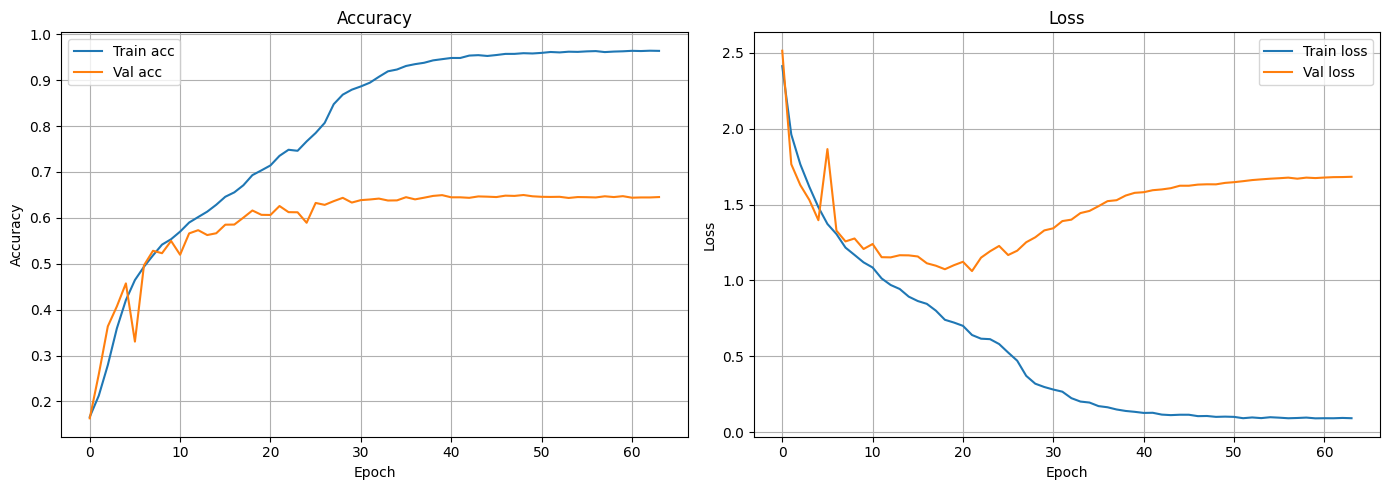

In [15]:
# Accuracy & Loss plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train acc')
axes[0].plot(history.history['val_accuracy'], label='Val acc')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Train loss')
axes[1].plot(history.history['val_loss'], label='Val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
VALIDATION RESULTS
              precision    recall  f1-score   support

       angry     0.5694    0.5671    0.5683       499
     disgust     0.4925    0.6000    0.5410        55
        fear     0.5072    0.4844    0.4955       512
       happy     0.8826    0.7916    0.8346       902
     neutral     0.5925    0.6393    0.6150       621
         sad     0.5301    0.5248    0.5275       604
    surprise     0.6906    0.8005    0.7415       396

    accuracy                         0.6434      3589
   macro avg     0.6093    0.6297    0.6176      3589
weighted avg     0.6488    0.6434    0.6447      3589

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

TEST RESULTS
              precision    recall  f1-score   support

       angry     0.5502    0.5553    0.5527       958
     disgust     0.5035    0.6396    0.5635       111
        fear     0.4708    0.4482    0.4592      1024
       happy     0.9093    0.8083    0.8559      1774
     neutral    

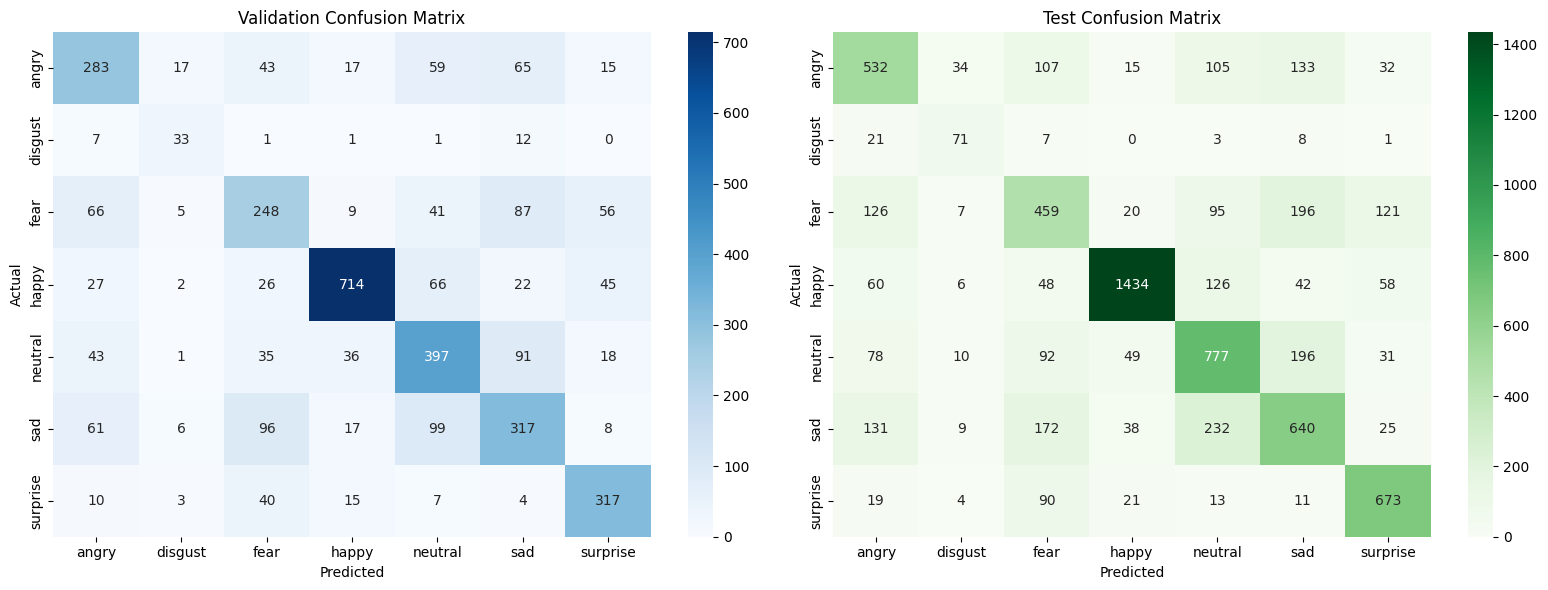


Validation Accuracy: 0.6434 (64.34%)
Test Accuracy:       0.6389 (63.89%)


In [16]:
# VALIDATION
y_val_pred = improved_cnn_v2.predict(X_val_cnn)
y_val_pred_int = np.argmax(y_val_pred, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

print("="*70)
print("VALIDATION RESULTS")
print("="*70)
print(classification_report(y_val_true_int, y_val_pred_int,
                           target_names=label_encoder.classes_, digits=4))

# TEST
y_test_pred = improved_cnn_v2.predict(X_test_cnn)
y_test_pred_int = np.argmax(y_test_pred, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)

print("\n" + "="*70)
print("TEST RESULTS")
print("="*70)
print(classification_report(y_test_true_int, y_test_pred_int,
                           target_names=label_encoder.classes_, digits=4))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_val = confusion_matrix(y_val_true_int, y_val_pred_int)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_test = confusion_matrix(y_test_true_int, y_test_pred_int)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Summary
val_acc = (y_val_pred_int == y_val_true_int).mean()
test_acc = (y_test_pred_int == y_test_true_int).mean()
print(f"\n{'='*70}")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*70}")

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check if data is ready
print("X_train_cnn shape:", X_train_cnn.shape)  # Expect to be (25120, 48, 48, 1)
print("y_train_cat shape:", y_train_cat.shape)  # Expect tp be (25120, 7)
print("num_classes:", num_classes)
print("Data is ready for ResNet-like")

X_train_cnn shape: (25120, 48, 48, 1)
y_train_cat shape: (25120, 7)
num_classes: 7
Data is ready for ResNet-like


In [19]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    # Shortcut
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same', name=name+'_0_conv')(x)
        shortcut = BatchNormalization(name=name+'_0_bn')(shortcut)
    else:
        shortcut = x

    # Main path
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_1_conv')(x)
    x = BatchNormalization(name=name+'_1_bn')(x)
    x = Activation('relu', name=name+'_1_relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same', name=name+'_2_conv')(x)
    x = BatchNormalization(name=name+'_2_bn')(x)

    x = Add(name=name+'_add')([shortcut, x])
    x = Activation('relu', name=name+'_out')(x)

    return x

print("Residual block without L2 defined")

Residual block without L2 defined


In [20]:
def build_resnet_for_small_images(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape, name='input')

    # Data Augmentation
    x = layers.RandomRotation(0.05)(inputs)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomFlip("horizontal")(x)

    # MODIFIED STEM. Standard ResNet uses kernel=7, stride=2. We use kernel=3, stride=1
    # to preserve the 48x48 resolution longer.
    x = Conv2D(64, (3,3), strides=1, padding='same', name='stem_conv')(x)
    x = BatchNormalization(name='stem_bn')(x)
    x = Activation('relu', name='stem_relu')(x)

    # Stage 1: 64 filters (Output: 48x48)
    x = residual_block(x, 64, name='stage1_blk1')
    x = residual_block(x, 64, name='stage1_blk2')
    x = Dropout(0.2)(x) # Light dropout between blocks

    # 128 filters (Output: 24x24 - Downsampling here is safe)
    x = residual_block(x, 128, stride=2, conv_shortcut=True, name='stage2_blk1')
    x = residual_block(x, 128, name='stage2_blk2')
    x = Dropout(0.3)(x)

    # 256 filters (Output: 12x12)
    x = residual_block(x, 256, stride=2, conv_shortcut=True, name='stage3_blk1')
    x = residual_block(x, 256, name='stage3_blk2')
    x = Dropout(0.4)(x)

    # 512 filters
    x = residual_block(x, 512, stride=2, conv_shortcut=True, name='stage4_blk1')
    x = residual_block(x, 512, name='stage4_blk2')
    x = Dropout(0.4)(x)

    # Classification Head
    x = GlobalAveragePooling2D(name='avg_pool')(x)

    # Added Dense Layer for better feature combination
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='ResNet_Small_Input_Optimized')
    return model

In [21]:
resnet_small = build_resnet_for_small_images(input_shape=(48, 48, 1), num_classes=7)
model.summary()

resnet_small.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("ResNet-like model compiled")

Model: "ResNet_Small_Input_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 48, 48, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_3   │ (None, 48, 48, 1) │          0 │ input[0][0]       │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 48, 48, 1) │          0 │ random_rotation_… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 48, 48, 1) │          0 │ random_translati… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 48, 48,    │        640 │ random_flip_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 48, 48,    │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu           │ (None, 48, 48,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_1_conv  │ (None, 48, 48,    │     36,928 │ stem_relu[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_1_bn    │ (None, 48, 48,    │        256 │ stage1_blk1_1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_1_relu  │ (None, 48, 48,    │          0 │ stage1_blk1_1_bn… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_2_conv  │ (None, 48, 48,    │     36,928 │ stage1_blk1_1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_2_bn    │ (None, 48, 48,    │        256 │ stage1_blk1_2_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_add     │ (None, 48, 48,    │          0 │ stem_relu[0][0],  │
│ (Add)               │ 64)               │            │ stage1_blk1_2_bn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk1_out     │ (None, 48, 48,    │          0 │ stage1_blk1_add[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk2_1_conv  │ (None, 48, 48,    │     36,928 │ stage1_blk1_out[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk2_1_bn    │ (None, 48, 48,    │        256 │ stage1_blk2_1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_blk2_1_relu  │ (None, 48, 48,    │          0 │ stage1_blk2_1_bn… │
│ (Activation)        │ 64)               │            │                 

 Total params: 11,450,375 (43.68 MB)

 Trainable params: 11,439,751 (43.64 MB)

 Non-trainable params: 10,624 (41.50 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,552,983 (82.22 MB)

 Trainable params: 7,182,535 (27.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 14,365,072 (54.80 MB)

ResNet-like model compiled


In [22]:
# Callbacks
early_stop_resnet_opt = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint_resnet_opt = callbacks.ModelCheckpoint(
    'resnet_opt_48x48_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_resnet_opt = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

print("Callbacks configured for Optimized ResNet")

Callbacks configured for Optimized ResNet


In [24]:
# TRAINING: Optimized ResNet

history_resnet_opt = resnet_small.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=80,
    batch_size=64,
    class_weight=cwdict,
    callbacks=[early_stop_resnet_opt, checkpoint_resnet_opt, reduce_lr_resnet_opt],
    verbose=2
)

resnet_small.save('resnet_opt_48x48_final.keras')

!cp resnet_opt_48x48_best.keras /content/drive/MyDrive/FER2013_data/
!cp resnet_opt_48x48_final.keras /content/drive/MyDrive/FER2013_data/

print("\nOptimized ResNet model saved locally and to Drive!")

Epoch 1/80

Epoch 1: val_accuracy improved from -inf to 0.17860, saving model to resnet_opt_48x48_best.keras
393/393 - 86s - 219ms/step - accuracy: 0.1619 - loss: 2.2797 - val_accuracy: 0.1786 - val_loss: 18.2454 - learning_rate: 5.0000e-04
Epoch 2/80

Epoch 2: val_accuracy improved from 0.17860 to 0.18835, saving model to resnet_opt_48x48_best.keras
393/393 - 140s - 355ms/step - accuracy: 0.1673 - loss: 2.1784 - val_accuracy: 0.1884 - val_loss: 2.2312 - learning_rate: 5.0000e-04
Epoch 3/80

Epoch 3: val_accuracy improved from 0.18835 to 0.19058, saving model to resnet_opt_48x48_best.keras
393/393 - 139s - 355ms/step - accuracy: 0.1641 - loss: 2.1023 - val_accuracy: 0.1906 - val_loss: 3.7491 - learning_rate: 5.0000e-04
Epoch 4/80

Epoch 4: val_accuracy improved from 0.19058 to 0.20981, saving model to resnet_opt_48x48_best.keras
393/393 - 81s - 206ms/step - accuracy: 0.1869 - loss: 2.0528 - val_accuracy: 0.2098 - val_loss: 2.1763 - learning_rate: 5.0000e-04
Epoch 5/80

Epoch 5: val_acc

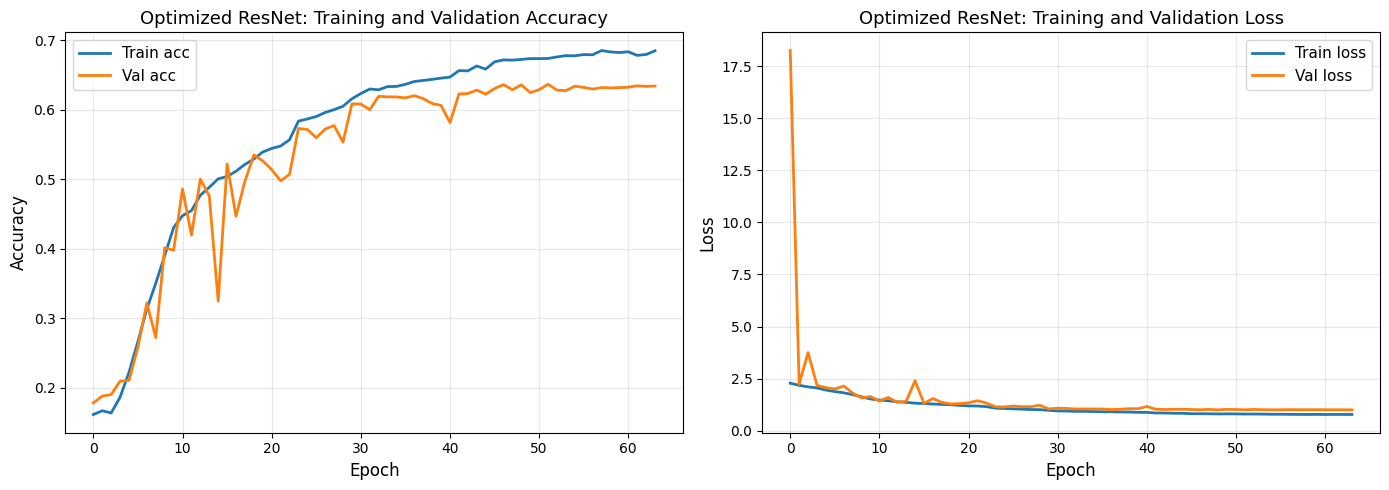

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_resnet_opt.history['accuracy'], label='Train acc', linewidth=2)
axes[0].plot(history_resnet_opt.history['val_accuracy'], label='Val acc', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Optimized ResNet: Training and Validation Accuracy', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_resnet_opt.history['loss'], label='Train loss', linewidth=2)
axes[1].plot(history_resnet_opt.history['val_loss'], label='Val loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Optimized ResNet: Training and Validation Loss', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
VALIDATION RESULTS - Optimized ResNet
              precision    recall  f1-score   support

       angry     0.5956    0.5431    0.5681       499
     disgust     0.5079    0.5818    0.5424        55
        fear     0.5153    0.4609    0.4866       512
       happy     0.8712    0.8027    0.8355       902
     neutral     0.5464    0.7021    0.6145       621
         sad     0.5137    0.4652    0.4883       604
    surprise     0.6957    0.7677    0.7299       396

    accuracy                         0.6364      3589
   macro avg     0.6065    0.6176    0.6093      3589
weighted avg     0.6408    0.6364    0.6357      3589


TEST RESULTS - Optimized ResNet
              precision    recall  f1-score   support

       angry     0.5772    0.5699    0.5735       958
     disgust     0.5423    0.6937    0.6087       111
        fear     0.5040    0.4346    0.4667      1024
       happy     0.8942    0.82

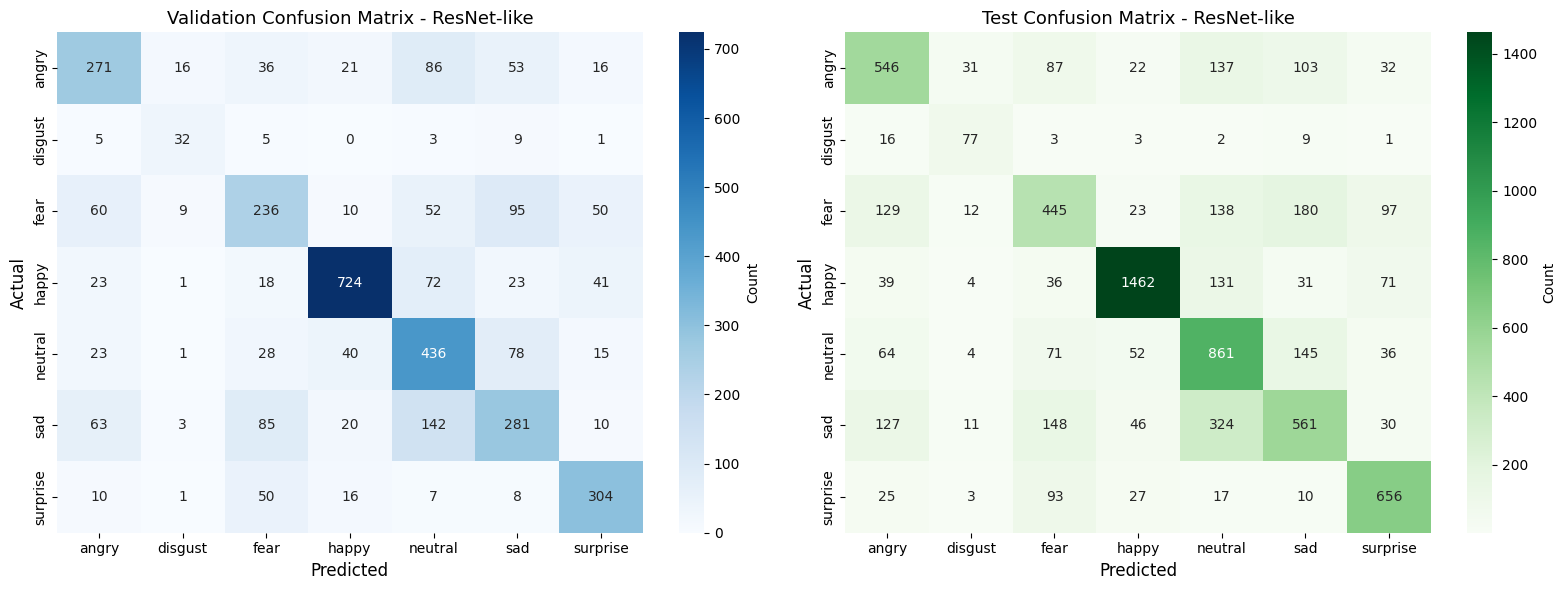


Validation Accuracy: 0.6364 (63.64%)
Test Accuracy:       0.6420 (64.20%)


In [26]:
# ===== PREDICTIONS =====
y_val_pred_resnet = resnet_small.predict(X_val_cnn)
y_val_pred_int_resnet = np.argmax(y_val_pred_resnet, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

y_test_pred_resnet = resnet_small.predict(X_test_cnn)
y_test_pred_int_resnet = np.argmax(y_test_pred_resnet, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)

# ===== VALIDATION METRICS =====
print("="*70)
print("VALIDATION RESULTS - Optimized ResNet")
print("="*70)
print(classification_report(
    y_val_true_int,
    y_val_pred_int_resnet,
    target_names=label_encoder.classes_,
    digits=4
))

# ===== TEST METRICS =====
print("\n" + "="*70)
print("TEST RESULTS - Optimized ResNet")
print("="*70)
print(classification_report(
    y_test_true_int,
    y_test_pred_int_resnet,
    target_names=label_encoder.classes_,
    digits=4
))

# ===== CONFUSION MATRICES =====
cm_val_resnet = confusion_matrix(y_val_true_int, y_val_pred_int_resnet)
cm_test_resnet = confusion_matrix(y_test_true_int, y_test_pred_int_resnet)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation CM
sns.heatmap(cm_val_resnet, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Validation Confusion Matrix - ResNet-like', fontsize=13)

# Test CM
sns.heatmap(cm_test_resnet, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Greens', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Test Confusion Matrix - ResNet-like', fontsize=13)

plt.tight_layout()
plt.show()

# ===== SUMMARY =====
val_acc_resnet = (y_val_pred_int_resnet == y_val_true_int).mean()
test_acc_resnet = (y_test_pred_int_resnet == y_test_true_int).mean()

print("\n" + "="*70)
print(f"Validation Accuracy: {val_acc_resnet:.4f} ({val_acc_resnet*100:.2f}%)")
print(f"Test Accuracy:       {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")
print("="*70)

In [27]:
from tensorflow.keras.optimizers import SGD
import numpy as np

print("for VGG11")

for VGG11


In [28]:
def build_vgg11_fer(input_shape=(48, 48, 1), num_classes=7):

    inputs = Input(shape=input_shape, name='input')

    # Moderate augmentation
    x = layers.RandomRotation(0.1, name='aug_rotation')(inputs)
    x = layers.RandomTranslation(0.1, 0.1, name='aug_translation')(x)
    x = layers.RandomFlip("horizontal", name='aug_flip')(x)

    # Block 1: 64 filters (1 conv)
    x = Conv2D(64, 3, padding='same', name='block1_conv')(x)
    x = BatchNormalization(name='block1_bn')(x)
    x = Activation('relu', name='block1_relu')(x)
    x = MaxPooling2D(2, name='block1_pool')(x)

    # Block 2: 128 filters (1 conv)
    x = Conv2D(128, 3, padding='same', name='block2_conv')(x)
    x = BatchNormalization(name='block2_bn')(x)
    x = Activation('relu', name='block2_relu')(x)
    x = MaxPooling2D(2, name='block2_pool')(x)

    # Block 3: 256 filters (2 conv)
    x = Conv2D(256, 3, padding='same', name='block3_conv1')(x)
    x = BatchNormalization(name='block3_bn1')(x)
    x = Activation('relu', name='block3_relu1')(x)
    x = Conv2D(256, 3, padding='same', name='block3_conv2')(x)
    x = BatchNormalization(name='block3_bn2')(x)
    x = Activation('relu', name='block3_relu2')(x)
    x = MaxPooling2D(2, name='block3_pool')(x)

    # Block 4: 512 filters (2 conv)
    x = Conv2D(512, 3, padding='same', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Activation('relu', name='block4_relu1')(x)
    x = Conv2D(512, 3, padding='same', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Activation('relu', name='block4_relu2')(x)
    x = MaxPooling2D(2, name='block4_pool')(x)

    # Block 5: 512 filters (2 conv)
    x = Conv2D(512, 3, padding='same', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Activation('relu', name='block5_relu1')(x)
    x = Conv2D(512, 3, padding='same', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Activation('relu', name='block5_relu2')(x)
    x = MaxPooling2D(2, name='block5_pool')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Classifier
    x = Dropout(0.5, name='dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='VGG11_FER2013')

    return model

# Build model
vgg11_model = build_vgg11_fer(input_shape=(48, 48, 1), num_classes=7)
vgg11_model.summary()

print("\nVGG11 model built")

Model: "VGG11_FER2013"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_rotation (RandomRotation)   │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_translation                 │ (None, 48, 48, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_flip (RandomFlip)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv (Conv2D)            │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn (BatchNormalization)  │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_relu (Activation)        │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv (Conv2D)            │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn (BatchNormalization)  │ (None, 24, 24, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_relu (Activation)        │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn1 (BatchNormalization) │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu1 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn2 (BatchNormalization) │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_relu2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_bn1 (BatchNormalization) │ (None, 6, 6, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_relu1 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_bn2 (BatchNormalization) │ (None, 6, 6, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,233,927 (35.22 MB)

 Trainable params: 9,228,423 (35.20 MB)

 Non-trainable params: 5,504 (21.50 KB)


VGG11 model built


In [29]:
def step_decay_schedule(epoch, lr):

    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10.0
    new_lr = initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))
    return new_lr

lr_scheduler = callbacks.LearningRateScheduler(step_decay_schedule, verbose=1)

print("Step Decay LR Scheduler configured")

Step Decay LR Scheduler configured


In [30]:
vgg11_model.compile(
    optimizer=SGD(
        learning_rate=0.01,
        momentum=0.9,
        nesterov=True
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("VGG11 compiled with SGD optimizer")

VGG11 compiled with SGD optimizer


In [31]:
early_stop_vgg11 = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint_vgg11 = callbacks.ModelCheckpoint(
    'vgg11_fer_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("Callbacks configured")

Callbacks configured


In [32]:
print("TRAINING: VGG11")

history_vgg11 = vgg11_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=60,
    batch_size=128,
    class_weight=cwdict,
    callbacks=[early_stop_vgg11, checkpoint_vgg11, lr_scheduler],
    verbose=2
)

vgg11_model.save('vgg11_fer_final.keras')

# Save to Drive
!cp vgg11_fer_best.keras /content/drive/MyDrive/FER2013_data/
!cp vgg11_fer_final.keras /content/drive/MyDrive/FER2013_data/

print("\nVGG11 model saved")

TRAINING: VGG11

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.25132, saving model to vgg11_fer_best.keras
197/197 - 25s - 125ms/step - accuracy: 0.1503 - loss: 2.3654 - val_accuracy: 0.2513 - val_loss: 1.8968 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/60

Epoch 2: val_accuracy did not improve from 0.25132
197/197 - 18s - 90ms/step - accuracy: 0.1623 - loss: 1.9964 - val_accuracy: 0.0156 - val_loss: 2.0650 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/60

Epoch 3: val_accuracy did not improve from 0.25132
197/197 - 18s - 90ms/step - accuracy: 0.1697 - loss: 1.9353 - val_accuracy: 0.1037 - val_loss: 2.0016 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/60

Epoch 4: val_accuracy did not improve from 0.25132
197/197 - 18s - 89ms/step - accuracy: 0.1940 - loss: 1.8796 - 

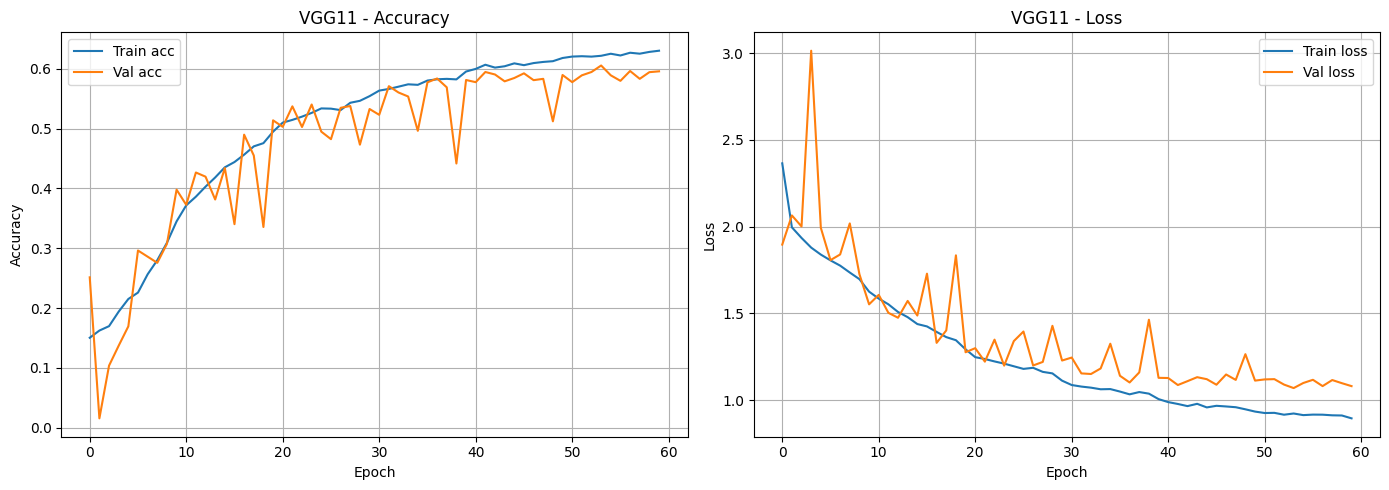


Training history plotted


In [33]:
# Accuracy & Loss plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_vgg11.history['accuracy'], label='Train acc')
axes[0].plot(history_vgg11.history['val_accuracy'], label='Val acc')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('VGG11 - Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_vgg11.history['loss'], label='Train loss')
axes[1].plot(history_vgg11.history['val_loss'], label='Val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('VGG11 - Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nTraining history plotted")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
VALIDATION RESULTS - VGG11
              precision    recall  f1-score   support

       angry     0.5156    0.5311    0.5232       499
     disgust     0.5435    0.4545    0.4950        55
        fear     0.4729    0.3750    0.4183       512
       happy     0.8376    0.8004    0.8186       902
     neutral     0.4920    0.6940    0.5758       621
         sad     0.5237    0.4387    0.4775       604
    surprise     0.7203    0.6894    0.7045       396

    accuracy                         0.6055      3589
   macro avg     0.5865    0.5690    0.5733      3589
weighted avg     0.6107    0.6055    0.6035      3589


TEST RESULTS - VGG11
              precision    recall  f1-score   support

       angry     0.4986    0.5501    0.5231       958
     disgust     0.6271    0.6667    0.6463       111
        fear     0.4626    0.3506    0.3989      1024
       happy     0.8602    0.7875    0.8222      1774


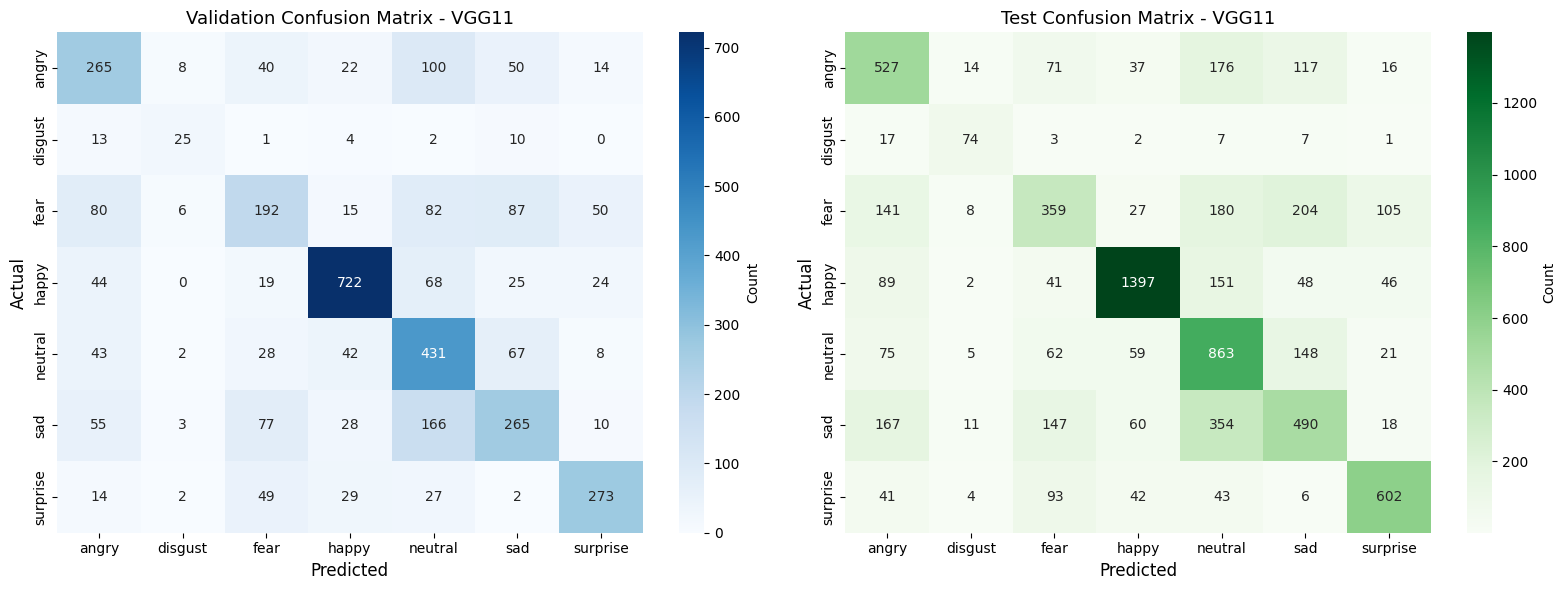


VGG11 Validation Accuracy: 0.6055 (60.55%)
VGG11 Test Accuracy:       0.6007 (60.07%)


In [34]:
# ===== PREDICTIONS - VGG11 =====
y_val_pred_vgg11 = vgg11_model.predict(X_val_cnn)
y_val_pred_int_vgg11 = np.argmax(y_val_pred_vgg11, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

y_test_pred_vgg11 = vgg11_model.predict(X_test_cnn)
y_test_pred_int_vgg11 = np.argmax(y_test_pred_vgg11, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)


# ===== VALIDATION METRICS - VGG11 =====
print("="*70)
print("VALIDATION RESULTS - VGG11")
print("="*70)
print(classification_report(
    y_val_true_int,
    y_val_pred_int_vgg11,
    target_names=label_encoder.classes_,
    digits=4
))


# ===== TEST METRICS - VGG11 =====
print("\n" + "="*70)
print("TEST RESULTS - VGG11")
print("="*70)
print(classification_report(
    y_test_true_int,
    y_test_pred_int_vgg11,
    target_names=label_encoder.classes_,
    digits=4
))


# ===== CONFUSION MATRICES - VGG11 =====
cm_val_vgg11 = confusion_matrix(y_val_true_int, y_val_pred_int_vgg11)
cm_test_vgg11 = confusion_matrix(y_test_true_int, y_test_pred_int_vgg11)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation CM
sns.heatmap(cm_val_vgg11, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Validation Confusion Matrix - VGG11', fontsize=13)

# Test CM
sns.heatmap(cm_test_vgg11, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Greens', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Test Confusion Matrix - VGG11', fontsize=13)

plt.tight_layout()
plt.show()


# ===== SUMMARY - VGG11 =====
val_acc_vgg11 = (y_val_pred_int_vgg11 == y_val_true_int).mean()
test_acc_vgg11 = (y_test_pred_int_vgg11 == y_test_true_int).mean()

print("\n" + "="*70)
print(f"VGG11 Validation Accuracy: {val_acc_vgg11:.4f} ({val_acc_vgg11*100:.2f}%)")
print(f"VGG11 Test Accuracy:       {test_acc_vgg11:.4f} ({test_acc_vgg11*100:.2f}%)")
print("="*70)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_vgg11_fer_optimized(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape, name='input')

    # Augmentation (Standard)
    x = layers.RandomRotation(0.1)(inputs)
    x = layers.RandomTranslation(0.1, 0.1)(x)
    x = layers.RandomFlip("horizontal")(x)

    # Layer 1: 64 filters (48x48 -> 24x24)
    x = Conv2D(64, 3, padding='same', activation='relu', name='block1_conv')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, name='block1_pool')(x)

    # Layer 2: 128 filters (24x24 -> 12x12)
    x = Conv2D(128, 3, padding='same', activation='relu', name='block2_conv')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, name='block2_pool')(x)

    # Layer 3: 256 filters (12x12 -> 6x6)
    x = Conv2D(256, 3, padding='same', activation='relu', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, 3, padding='same', activation='relu', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, name='block3_pool')(x)

    # Layer 4: 512 filters (6x6 -> 3x3)
    x = Conv2D(512, 3, padding='same', activation='relu', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, padding='same', activation='relu', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, name='block4_pool')(x)

    # Layer 5: 512 filters (REMAIN 3x3 - NO POOLING)
    # This is the key fix. We keep spatial info for the classifier.
    x = Conv2D(512, 3, padding='same', activation='relu', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, padding='same', activation='relu', name='block5_conv2')(x)
    x = BatchNormalization()(x)

    # Classifier Head
    x = Flatten(name='flatten')(x)

    x = Dense(512, activation='relu', name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu', name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='VGG11_Optimized_48x48')
    return model

vgg11_opt = build_vgg11_fer_optimized()
vgg11_opt.summary()
print("Optimized VGG11 built successfully.")

Model: "VGG11_Optimized_48x48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 48, 48, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_3            │ (None, 48, 48, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv (Conv2D)            │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv (Conv2D)            │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,80

 Total params: 11,860,487 (45.24 MB)

 Trainable params: 11,852,935 (45.22 MB)

 Non-trainable params: 7,552 (29.50 KB)

Optimized VGG11 built successfully.


In [36]:
vgg11_opt.compile(
    optimizer=optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with Adam (lr=0.0003)")

# Callbacks
early_stop_vgg = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

checkpoint_vgg = callbacks.ModelCheckpoint(
    'vgg11_opt_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr_vgg = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

print("Callbacks configured")

Model compiled with Adam (lr=0.0003)
Callbacks configured


In [37]:
# TRAINING: Optimized VGG11

history_vgg11 = vgg11_opt.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=60,
    batch_size=64,
    class_weight=cwdict,
    callbacks=[early_stop_vgg, checkpoint_vgg, reduce_lr_vgg],
    verbose=2
)

# Save Final
vgg11_opt.save('vgg11_opt_final.keras')

# Save into Drive
!cp vgg11_opt_best.keras /content/drive/MyDrive/FER2013_data/
!cp vgg11_opt_final.keras /content/drive/MyDrive/FER2013_data/

print("\nOptimized VGG11 Saved!")

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.15297, saving model to vgg11_opt_best.keras
393/393 - 33s - 83ms/step - accuracy: 0.1608 - loss: 2.6892 - val_accuracy: 0.1530 - val_loss: 2.1667 - learning_rate: 3.0000e-04
Epoch 2/60

Epoch 2: val_accuracy improved from 0.15297 to 0.23433, saving model to vgg11_opt_best.keras
393/393 - 39s - 99ms/step - accuracy: 0.1693 - loss: 2.3499 - val_accuracy: 0.2343 - val_loss: 2.0312 - learning_rate: 3.0000e-04
Epoch 3/60

Epoch 3: val_accuracy did not improve from 0.23433
393/393 - 24s - 60ms/step - accuracy: 0.1832 - loss: 2.1615 - val_accuracy: 0.2329 - val_loss: 1.9156 - learning_rate: 3.0000e-04
Epoch 4/60

Epoch 4: val_accuracy did not improve from 0.23433
393/393 - 23s - 59ms/step - accuracy: 0.1969 - loss: 2.0538 - val_accuracy: 0.2017 - val_loss: 1.8772 - learning_rate: 3.0000e-04
Epoch 5/60

Epoch 5: val_accuracy did not improve from 0.23433
393/393 - 24s - 60ms/step - accuracy: 0.2133 - loss: 1.9957 - val_accuracy: 0.2062 -

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

VALIDATION RESULTS - Optimized VGG11
              precision    recall  f1-score   support

       angry     0.5353    0.5932    0.5627       499
     disgust     0.5682    0.4545    0.5051        55
        fear     0.5236    0.4121    0.4612       512
       happy     0.8602    0.8049    0.8316       902
     neutral     0.5256    0.6441    0.5789       621
         sad     0.4940    0.4768    0.4853       604
    surprise     0.7282    0.7374    0.7327       396

    accuracy                         0.6236      3589
   macro avg     0.6050    0.5890    0.5939      3589
weighted avg     0.6284    0.6236    0.6235      3589


TEST RESULTS - Optimized VGG11
              precision    recall  f1-score   support

       angry     0.5133    0.6065    0.5560       958
     disgust     0.6355    0.6126    0.6239       111
        fear     0.5019    0.3896    0.4387      1024
       happy     0.8792    0.8083

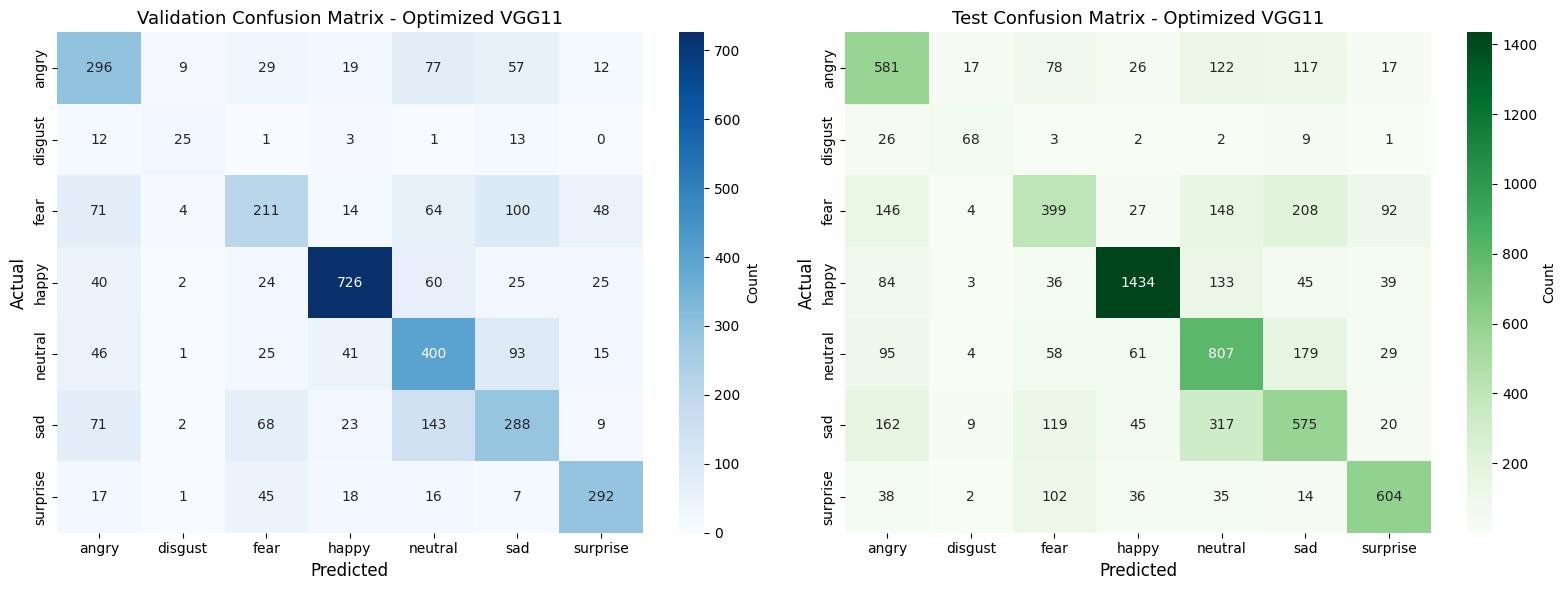


Optimized VGG11 Validation Accuracy: 0.6236 (62.36%)
Optimized VGG11 Test Accuracy:       0.6225 (62.25%)


In [39]:
# ===== PREDICTIONS - Optimized VGG11 =====
y_val_pred_vgg_opt = vgg11_opt.predict(X_val_cnn, verbose=1)
y_val_pred_int_vgg_opt = np.argmax(y_val_pred_vgg_opt, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

y_test_pred_vgg_opt = vgg11_opt.predict(X_test_cnn, verbose=1)
y_test_pred_int_vgg_opt = np.argmax(y_test_pred_vgg_opt, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)

# ===== VALIDATION METRICS - Optimized VGG11 =====
print("\n" + "="*70)
print("VALIDATION RESULTS - Optimized VGG11")
print("="*70)
print(classification_report(
    y_val_true_int,
    y_val_pred_int_vgg_opt,
    target_names=label_encoder.classes_,
    digits=4
))

# ===== TEST METRICS - Optimized VGG11 =====
print("\n" + "="*70)
print("TEST RESULTS - Optimized VGG11")
print("="*70)
print(classification_report(
    y_test_true_int,
    y_test_pred_int_vgg_opt,
    target_names=label_encoder.classes_,
    digits=4
))

# ===== CONFUSION MATRICES - Optimized VGG11 =====
cm_val_vgg_opt = confusion_matrix(y_val_true_int, y_val_pred_int_vgg_opt)
cm_test_vgg_opt = confusion_matrix(y_test_true_int, y_test_pred_int_vgg_opt)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation CM
sns.heatmap(cm_val_vgg_opt, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Validation Confusion Matrix - Optimized VGG11', fontsize=13)

# Test CM
sns.heatmap(cm_test_vgg_opt, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Greens', ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Test Confusion Matrix - Optimized VGG11', fontsize=13)

plt.tight_layout()
plt.show()

# ===== SUMMARY - Optimized VGG11 =====
val_acc_vgg_opt = (y_val_pred_int_vgg_opt == y_val_true_int).mean()
test_acc_vgg_opt = (y_test_pred_int_vgg_opt == y_test_true_int).mean()

print("\n" + "="*70)
print(f"Optimized VGG11 Validation Accuracy: {val_acc_vgg_opt:.4f} ({val_acc_vgg_opt*100:.2f}%)")
print(f"Optimized VGG11 Test Accuracy:       {test_acc_vgg_opt:.4f} ({test_acc_vgg_opt*100:.2f}%)")
print("="*70)

In [40]:
# ENSEMBLE (3 MODELS TOGETHER)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Improved Best CNN
model_cnn = load_model('improved_cnn_best.keras')
print("loaded: improved_cnn_best.keras")

# Improved ResNet
model_resnet = load_model('improved_resnet_like_fer_best.keras')
print("loaded: improved_resnet_like_fer_best.keras")

# Optimized VGG11(The Poet)
model_vgg = load_model('vgg11_opt_best.keras')
print("loaded: vgg11_opt_best.keras")

print("\nModels ready for Ensemble")

loaded: improved_cnn_best.keras
loaded: improved_resnet_like_fer_best.keras
loaded: vgg11_opt_best.keras

Models ready for Ensemble


In [41]:
# Validation
val_pred_cnn = model_cnn.predict(X_val_cnn, verbose=0)
val_pred_res = model_resnet.predict(X_val_cnn, verbose=0)
val_pred_vgg = model_vgg.predict(X_val_cnn, verbose=0)

# Test
test_pred_cnn = model_cnn.predict(X_test_cnn, verbose=0)
test_pred_res = model_resnet.predict(X_test_cnn, verbose=0)
test_pred_vgg = model_vgg.predict(X_test_cnn, verbose=0)

print("\nPredictions complete")


Predictions complete



VALIDATION RESULTS (3-MODEL ENSEMBLE)
              precision    recall  f1-score   support

       angry     0.6453    0.5251    0.5790       499
     disgust     0.5273    0.5273    0.5273        55
        fear     0.5382    0.5371    0.5376       512
       happy     0.8317    0.8492    0.8404       902
     neutral     0.5822    0.6441    0.6116       621
         sad     0.5188    0.5248    0.5218       604
    surprise     0.7940    0.7980    0.7960       396

    accuracy                         0.6590      3589
   macro avg     0.6339    0.6294    0.6305      3589
weighted avg     0.6593    0.6590    0.6580      3589


TEST RESULTS (3-MODEL ENSEMBLE)
              precision    recall  f1-score   support

       angry     0.6471    0.5532    0.5965       958
     disgust     0.6818    0.6757    0.6787       111
        fear     0.5297    0.4961    0.5124      1024
       happy     0.8460    0.8546    0.8503      1774
     neutral     0.5901    0.6796    0.6317      1233
      

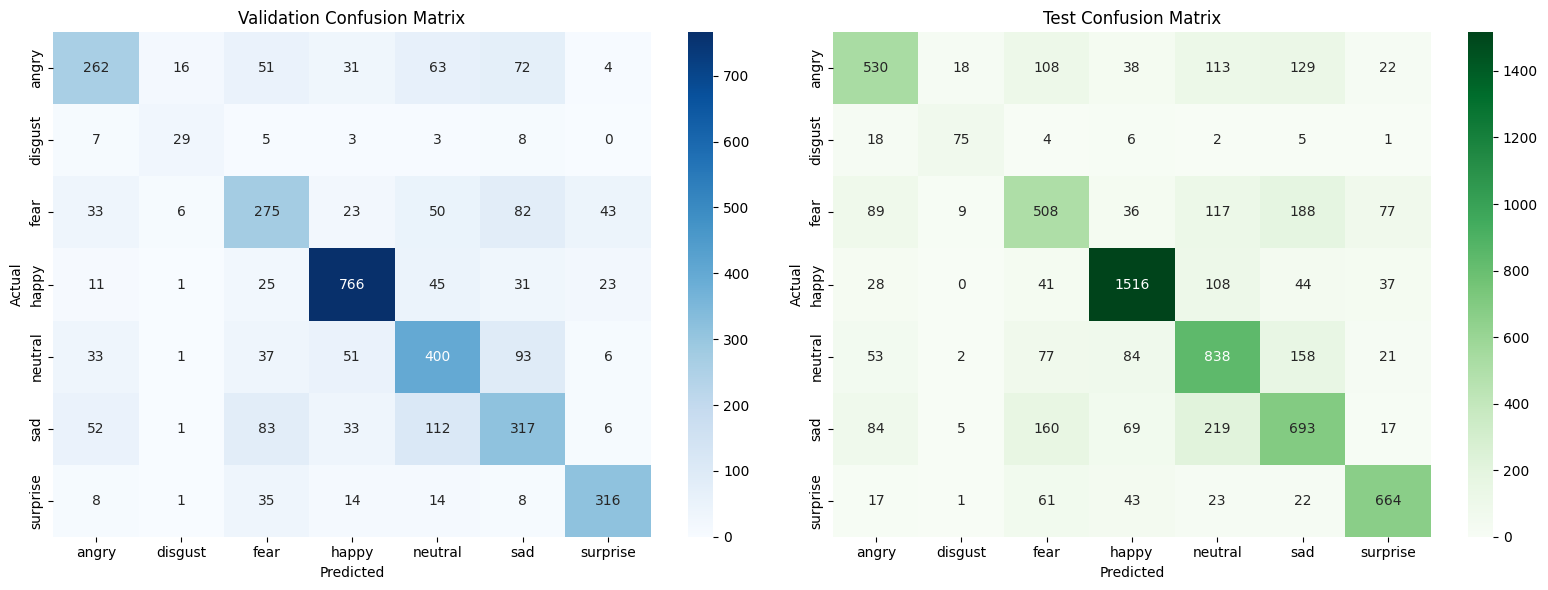


3-Model Ensemble Validation Accuracy: 0.6590 (65.90%)
3-Model Ensemble Test Accuracy:       0.6721 (67.21%)


In [42]:
# 3-MODEL ENSEMBLE METRICS RESULTS

# Weights: CNN (0.5), ResNet (0.3), VGG (0.2)

# Validation
y_val_pred_ensemble = (0.5 * val_pred_cnn) + (0.3 * val_pred_res) + (0.2 * val_pred_vgg)
y_val_pred_int = np.argmax(y_val_pred_ensemble, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

# Test
y_test_pred_ensemble = (0.5 * test_pred_cnn) + (0.3 * test_pred_res) + (0.2 * test_pred_vgg)
y_test_pred_int = np.argmax(y_test_pred_ensemble, axis=1)
y_test_true_int = np.argmax(y_test_cat, axis=1)

# ===== VALIDATION METRICS - 3-MODEL ENSEMBLE =====
print("\n" + "="*70)
print("VALIDATION RESULTS (3-MODEL ENSEMBLE)")
print("="*70)
print(classification_report(y_val_true_int, y_val_pred_int,
                            target_names=label_encoder.classes_, digits=4))

# ===== TEST METRICS - 3-MODEL ENSEMBLE =====
print("\n" + "="*70)
print("TEST RESULTS (3-MODEL ENSEMBLE)")
print("="*70)
print(classification_report(y_test_true_int, y_test_pred_int,
                            target_names=label_encoder.classes_, digits=4))


# ===== CONFUSION MATRICES - 3-MODEL ENSEMBLE =====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation Matrix
cm_val = confusion_matrix(y_val_true_int, y_val_pred_int)
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Validation Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test Matrix
cm_test = confusion_matrix(y_test_true_int, y_test_pred_int)
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Greens', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# FINAL SUMMARY
val_acc = accuracy_score(y_val_true_int, y_val_pred_int)
test_acc = accuracy_score(y_test_true_int, y_test_pred_int)

print("\n" + "="*70)
print(f"3-Model Ensemble Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"3-Model Ensemble Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
print("="*70)